In [35]:
import tensorflow as tf
from tensorflow.keras.models import  Sequential, Model
import numpy as np
import os
import random
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import cv2
import shutil # copies the image to another directory

In [75]:
source_directory = 'T:\\dogs-vs-cats\\train\\train'
source_test_directory = 'T:\\dogs-vs-cats\\test\\test'

In [10]:
# counting the number of images in the directory
def count_images(directory):
    count = 0
    for filename in os.listdir(directory):
        if filename.endswith(('.jpg', '.jpeg', '.png', '.gif', '.bmp')):
            count += 1
    return count
num_images = count_images(source_directory)
print(num_images)


25000


In [3]:
# counting number of images for each category present inside the directory
def get_image_counts(directory):
    category_counts = {}
    for filename in os.listdir(directory):
        if os.path.isdir(os.path.join(directory, filename)):
            category_counts[filename] = 0
        elif filename.endswith(('.jpg', '.jpeg', '.png', '.gif', '.bmp')):
            category_name = filename.split('.')[0]
            if category_name not in category_counts:
                category_counts[category_name] = 0
            category_counts[category_name] += 1
    return category_counts

image_counts = get_image_counts(train_dir)
for category, count in image_counts.items():
    print(f"{category} = {count}")


cat = 12500
dog = 12500


In [5]:

def getcatdogimages(source_dir):

    """
    to get the path of  image present in  the directory
    taking images  from the directory

    Args: source directory which contains images of cat and dog
    Returns: the list of cat and dog images
    """

    cat_images = []
    dog_images = []
    for filename in os.listdir(source_dir):
        if filename.startswith('cat'):
            cat_images.append(os.path.join(source_dir, filename))
        elif filename.startswith('dog'):
            dog_images.append(os.path.join(source_dir, filename))

    #selected_cat_images = random.sample(cat_images, 1000)
    #selected_dog_images = random.sample(dog_images, 1000)
    return cat_images,dog_images

In [6]:
# here i am passing the source directory which then returns the directory of images
getcatdogimages(source_directory)[1][0]

'T:\\dogs-vs-cats\\train\\train\\dog.0.jpg'

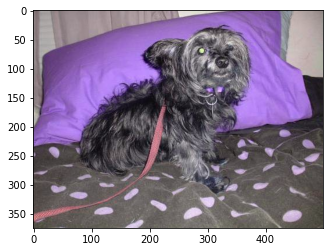

In [7]:
plt.imshow(cv2.imread(getcatdogimages(source_directory)[1][0]))

In [76]:
# since the original directory contains thousands of imags
# hence we are training neural network on few hundreds of image
# so we are copying these images into new directory called train_dir
train_directory = 'T:\\dogs-vs-cats\\train\\selected_train'
valid_directory = 'T:\\dogs-vs-cats\\train\\valid_directory'
test_directory = 'T:\\dogs-vs-cats\\test\\test_dir'

In [77]:
# do not call every time

def copying_imgs(source_dir,destination_dir,num_of_imgs):
    """
    this function copies the images from source directory to destination directory

    """

    if not os.path.exists(destination_dir):
     os.makedirs(destination_dir)

    cat_images = getcatdogimages(source_directory)[0] 
    dog_images = getcatdogimages(source_directory)[1] 
    selected_cat_images = random.sample(cat_images, num_of_imgs)
    selected_dog_images = random.sample(dog_images, num_of_imgs)

    for image_path in selected_cat_images:
        shutil.copy2(image_path, destination_dir)

    for image_path in selected_dog_images:
        shutil.copy2(image_path, destination_dir)
#uncommented as already copied
#copying_imgs(source_directory,train_directory,300)
#copying_imgs(source_directory,valid_directory,120)
copying_imgs(source_test_directory,test_directory,200)


In [42]:

def read_image_data(directory, target_size=(224, 224)):
    images = []
    labels = []

    for filename in os.listdir(directory):
        img_path = os.path.join(directory, filename)
        img = cv2.imread(img_path)

        # Resize the image to the target size
        resized_img = cv2.resize(img, target_size)

        # Pad the image with zeros to achieve a consistent shape
        padded_img = np.pad(resized_img, ((0, target_size[0] - resized_img.shape[0]), (0, target_size[1] - resized_img.shape[1]), (0, 0)), 'constant', constant_values=0)

        label = 0 if filename.startswith('cat') else 1

        images.append(padded_img)
        labels.append(label)

    return np.array(images), np.array(labels)


In [43]:
train_img,train_labels = read_image_data(train_directory)

In [71]:
valid_img,valid_labels = read_image_data(valid_directory)

In [78]:
test_img,test_labels = read_image_data(test_directory)

In [79]:
print(train_img.shape)
print(valid_img.shape)
print(test_img.shape)

(600, 224, 224, 3)
(240, 224, 224, 3)
(400, 224, 224, 3)


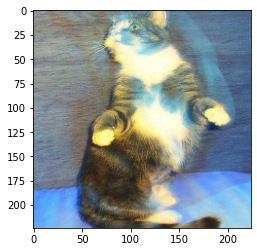

In [45]:
plt.imshow(train_img[0])

In [50]:
from tensorflow.keras.applications import MobileNetV2

model = MobileNetV2(weights='imagenet')


In [51]:
model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_3[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[

In [58]:
def remove_head(pretrained_model):

 """
    This function should create and return a new model, using the input and output 
    tensors as specified above. 
    Use the 'get_layer' method to access the correct layer of the pre-trained model.
    """  
    
    v2_input =   pretrained_model.get_layer('input_3').input
    v2_output =  pretrained_model.get_layer('global_average_pooling2d_2').output
    
    return Model(inputs=v2_input,outputs=v2_output)
    
  

In [59]:
feature_extractor = remove_head(model)
feature_extractor.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_3[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[0][0]']        

 block_2_depthwise_relu (Re  (None, 56, 56, 144)          0         ['block_2_depthwise_BN[0][0]']
 LU)                                                                                              
                                                                                                  
 block_2_project (Conv2D)    (None, 56, 56, 24)           3456      ['block_2_depthwise_relu[0][0]
                                                                    ']                            
                                                                                                  
 block_2_project_BN (BatchN  (None, 56, 56, 24)           96        ['block_2_project[0][0]']     
 ormalization)                                                                                    
                                                                                                  
 block_2_add (Add)           (None, 56, 56, 24)           0         ['block_1_project_BN[0][0]',  
          

In [60]:
from tensorflow.keras.layers import Dense,Dropout
from tensorflow.keras.models import Sequential

def add_new_classifier_head(feature_extractor_model):
    
    model = Sequential([
        feature_extractor_model,
        Dense(32,activation='relu'),
        Dropout(0.5),
        Dense(1,activation='sigmoid')
        
    ])
    return model

In [61]:
new_model = add_new_classifier_head(feature_extractor)
new_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model (Functional)          (None, 1280)              2257984   
                                                                 
 dense (Dense)               (None, 32)                40992     
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 2299009 (8.77 MB)
Trainable params: 2264897 (8.64 MB)
Non-trainable params: 34112 (133.25 KB)
_________________________________________________________________


In [62]:
def freeze_pretrained_weights(model):
    """
    this function takes the model and makes the 
    pretrained models weights false which ensures during training 
    the pretrained models weights will not changed.
    only the new layers weights change not the pretrained models weight.
    Args:
    takes the model
    Returns:
    the model with the properties just discussed
    """
    model.layers[0].trainable = False
    
    model.compile(optimizer = tf.keras.optimizers.RMSprop(0.001),
                  loss=tf.keras.losses.BinaryCrossentropy(), metrics = ['acc'])
    return model

In [63]:
frozen_new_model = freeze_pretrained_weights(new_model)
frozen_new_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model (Functional)          (None, 1280)              2257984   
                                                                 
 dense (Dense)               (None, 32)                40992     
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 2299009 (8.77 MB)
Trainable params: 41025 (160.25 KB)
Non-trainable params: 2257984 (8.61 MB)
_________________________________________________________________


In [73]:
earlystopping = tf.keras.callbacks.EarlyStopping(patience=2)
history_frozen_new_model = frozen_new_model.fit(train_img, train_labels, epochs=10, batch_size=32,
                                                validation_data=(valid_img, valid_labels), 
                                                callbacks=[earlystopping])

Epoch 1/10
19/19 [==============================] - 30s 2s/step - loss: 0.6308 - acc: 0.6700 - val_loss: 0.6595 - val_acc: 0.6333
Epoch 2/10
19/19 [==============================] - 29s 2s/step - loss: 0.5873 - acc: 0.6750 - val_loss: 0.6416 - val_acc: 0.6625
Epoch 3/10
19/19 [==============================] - 28s 2s/step - loss: 0.5969 - acc: 0.6783 - val_loss: 0.6239 - val_acc: 0.6458
Epoch 4/10
19/19 [==============================] - 28s 2s/step - loss: 0.5828 - acc: 0.7000 - val_loss: 0.6434 - val_acc: 0.6542
Epoch 5/10
19/19 [==============================] - 29s 2s/step - loss: 0.5543 - acc: 0.7233 - val_loss: 0.6740 - val_acc: 0.6167


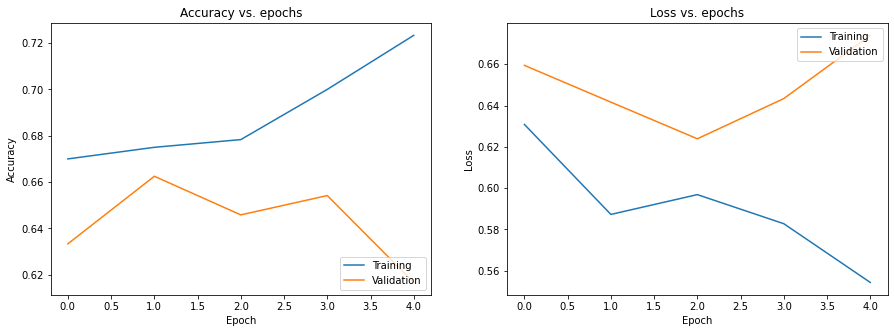

In [74]:
# Run this cell to plot accuracy vs epoch and loss vs epoch

plt.figure(figsize=(15,5))
plt.subplot(121)
try:
    plt.plot(history_frozen_new_model.history['accuracy'])
    plt.plot(history_frozen_new_model.history['val_accuracy'])
except KeyError:
    plt.plot(history_frozen_new_model.history['acc'])
    plt.plot(history_frozen_new_model.history['val_acc'])
plt.title('Accuracy vs. epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='lower right')

plt.subplot(122)
plt.plot(history_frozen_new_model.history['loss'])
plt.plot(history_frozen_new_model.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show() 

In [80]:
test_loss, test_acc = frozen_new_model.evaluate(test_img, test_labels, verbose=0)
print("Test loss: {}".format(test_loss))
print("Test accuracy: {}".format(test_acc))

Test loss: 0.6660041213035583
Test accuracy: 0.6449999809265137


13/13 [==============================] - 17s 1s/step


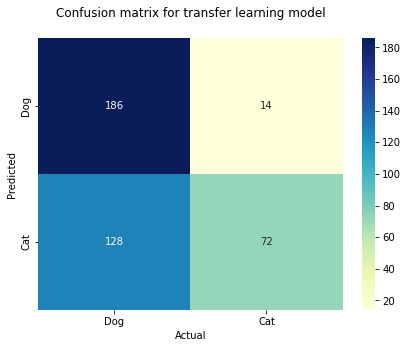

In [82]:
plt.figure(figsize=(15, 5))
preds = frozen_new_model.predict(test_img)
preds = (preds >= 0.5).astype(np.int32)
cm = confusion_matrix(test_labels, preds)
df_cm = pd.DataFrame(cm, index=['Dog', 'Cat'], columns=['Dog', 'Cat'])
plt.subplot(122)
plt.title("Confusion matrix for transfer learning model\n")
sns.heatmap(df_cm, annot=True, fmt="d", cmap="YlGnBu")
plt.ylabel("Predicted")
plt.xlabel("Actual")
plt.show()